---
## 🚀 Setup

Start out by preparing the requirements so you can start getting insights:

1. Install with dependencies

2. Import libraries and declare parameters

3. Get Superwise Token
---

**🪄 Declare parameters for this Notebook**

In [48]:
ACCOUNT_NAME = "demo"
CLIENT_ID = '[Client]'
SECRET = '[Secret]'
MODEL_NAME = 'Fraud Detection'
VERSION_NAME = 'v1.12'
FROM_DATE = '2022-03-01 00:00:00'
TO_DATE = '2022-03-31 00:00:00'

**Install And Imports**

In [2]:
%%sh
pip install -q "jupyterlab>=3" "ipywidgets>=7.6"
pip install jupyter-plotly-dash jupyter-dash dash==2.1.0
pip install -q plotly==5.4.0
pip install tornado

  Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
  Using cached importlib_metadata-2.1.3-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
django-bootstrap4 22.1 requires importlib-metadata<3; python_version < "3.8", but you have importlib-metadata 4.11.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.
jupyterlab-server 2.14.0 requires importlib-metadata>=3.6; python_version <

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from dash import Dash, dash_table
import pandas as pd
import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy as hc
from matplotlib import colors as mat_colors
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from matplotlib import pyplot as plt


pd.options.plotting.backend = "plotly"
plt.rcParams["figure.figsize"] = [24,10]
plt.rcParams["figure.autolayout"] = True
import requests

In [4]:
URL_PREFIX = f"https://portal.superwise.ai/{ACCOUNT_NAME}"

**Get Token**

In [5]:
url = "https://auth.superwise.ai/identity/resources/auth/v1/api-token"

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json"
}
payload = {
    "clientId": CLIENT_ID,
    "secret": SECRET
}

res = requests.post(url, json=payload, headers=headers)
res.raise_for_status()
token = res.json()['accessToken']
HEADERS = {"Authorization": f"Bearer {token}"}

**Extract model_id and version_id**

In [6]:
request_url  = f'{URL_PREFIX}/admin/v1/models?name={MODEL_NAME}'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()
MODEL_ID=res.json()[0]['id']
MODEL_ID

8

In [7]:
request_url  = f'{URL_PREFIX}/model/v1/versions?task_id={MODEL_ID}'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()
VERSION_ID = res.json()[0]['id']
VERSION_ID

7

# 🏃 Retraining Notebook 
By analyzing model production behavior, this Notebook helps you to better understand your model data and make decisions on how and when to retrain your models.

The Notebook covers the following topics:  

**[1️⃣. Data Dna + Clustering 🧬](#dna)**

**[2️⃣. Exclude days based on incidents amount 🆘 ](#incident)**

**[3️⃣. Most drifted features (relative to baseline) 📈](#drift)**

**[4️⃣. Most drifted segments (relative to baseline) 🌎 ](#segment)**



<a id='dna'></a>
## 1️⃣. 🧬 Data DNA Insights
Data DNA helps you understand how the data has changed between dates. It is also useful for suggesting potential dataset clusters based on similar distributions.

In [8]:
def plotMatrix(matrix, ax=None, title='Distance Matrix', cbar=True, show_ticks=True, figsize=(20,12)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    scale_max_val = max(0.1, matrix.max().max())
    
    if show_ticks:
        show_ticks = 'auto'
    
    mat = sns.heatmap(matrix, square=True, annot=False, xticklabels=show_ticks, yticklabels=show_ticks,
                      vmax=scale_max_val, vmin=0, cmap="Blues", ax=ax)
    
    
    if title:
        ax.set_title(title)

In [9]:
DNA_URL = f"{URL_PREFIX}/dna/v1/dna?task_id={MODEL_ID}"
params = {
    'version_id': VERSION_ID,
    "from_ts": FROM_DATE,
    "to_ts": TO_DATE
}
res = requests.get(DNA_URL, headers=HEADERS, params=params)
res.raise_for_status()
matrix = json.loads(res.content)['results']

In [10]:
matrix = pd.DataFrame(
    matrix['records'], 
    index=pd.to_datetime(matrix['dates'], unit='s').date, 
    columns=pd.to_datetime(matrix['dates'], unit='s').date
)

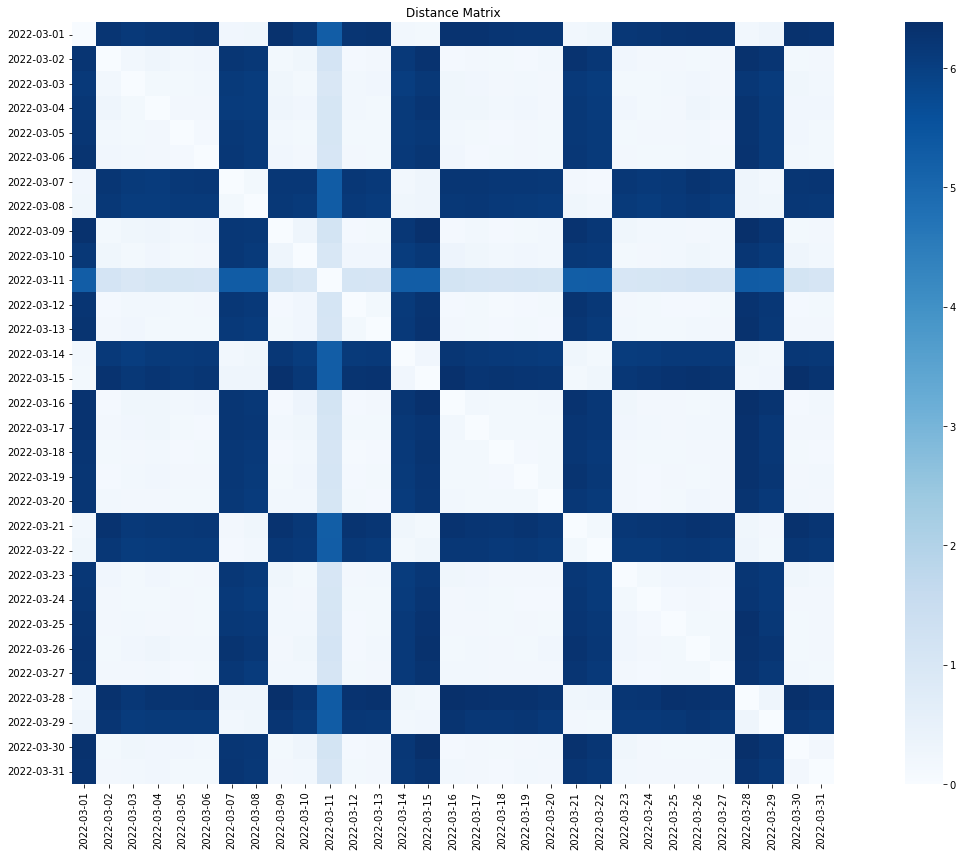

In [11]:
plotMatrix(matrix)

#### 👥  Create hierarchical groups

(465,)
Amount of groups - (30, 4)


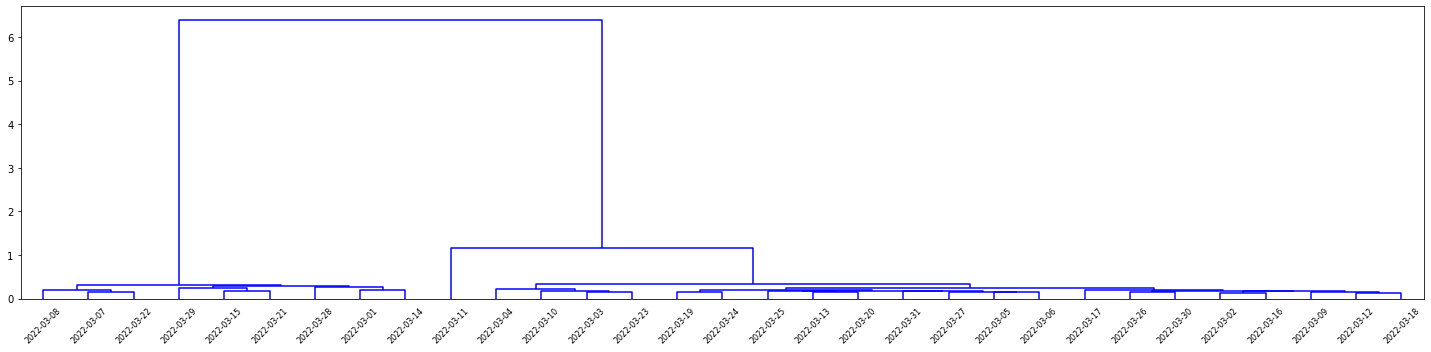

In [12]:
corr_condensed = hc.distance.squareform(matrix)
print(corr_condensed.shape)
z = hc.linkage(corr_condensed, method='complete')
print(f"Amount of groups - {z.shape}")
plt.figure(figsize=(20, 5))
plt.rcParams.update({'font.size': 10})
dendrogram = hc.dendrogram(z, labels=matrix.columns, color_threshold=0.03)
plt.show() 

In [13]:
clusters = hc.fcluster(z, 1.0, criterion='distance')
clusters.shape

(31,)

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_data_dna(matrix, clusters):
    colors_map = {i:c for i,c in enumerate(plt.rcParams['axes.prop_cycle'].by_key()['color'])}
    cluster_bar = pd.Series(clusters, index=matrix.index).map(colors_map)

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[20, 1]}, figsize=(15,12), sharex=False)

    sns.heatmap(matrix, ax= ax1, cmap='Blues')
    ax1.tick_params(axis='x', direction='out', pad=40)

    p1 = ax1.get_position().bounds
    p2 = ax2.get_position().bounds
    p2_new = list(p2)
    p2_new[0] = p1[0]
    p2_new[1] = p1[1] - p2[3] - 0.01
    p2_new[2] = p1[2]
    ax2.set_position(p2_new)

    ax2.bar(x=matrix.index,height=[1]*matrix.shape[0], width=1.0, color=cluster_bar)
    ax2.margins(0.00)  
    ax2.tick_params(labelbottom=False, bottom=False)

    _ = plt.xticks(rotation=90)
    
    return fig


#### 👥 Find different groups of dates with similar data

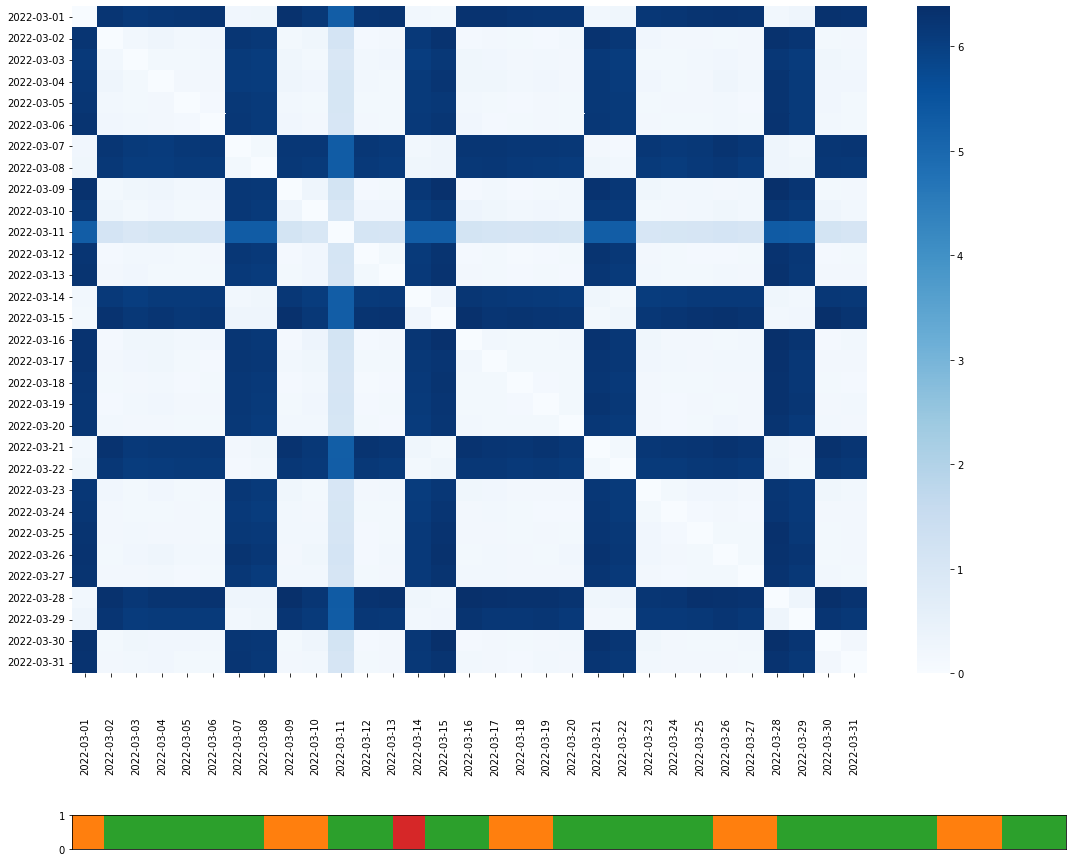

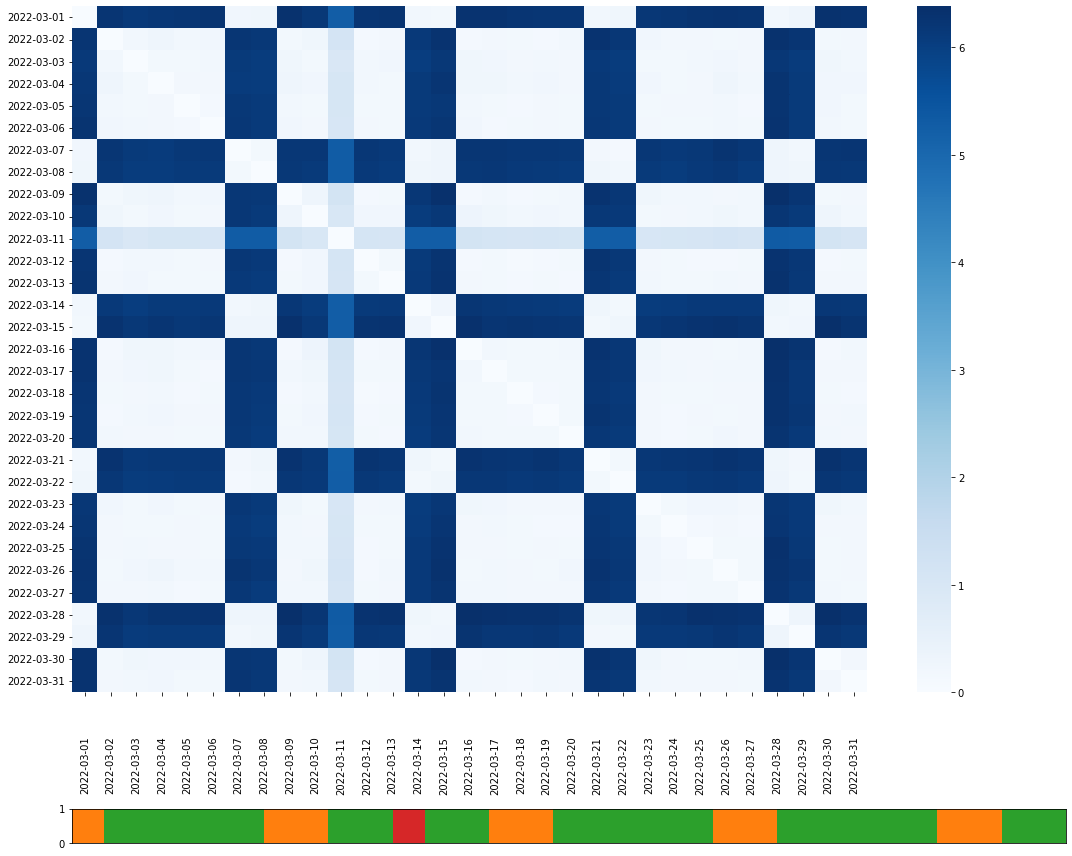

In [15]:
plot_data_dna(matrix, clusters)

#### 👥 Retraining Groups

In [16]:
groups_df = pd.DataFrame(data={"Dates" : list(matrix.columns), "Group" : clusters}).groupby('Group').agg(list).reset_index()
groups_df

,Group,Dates
0,1,"[2022-03-01, 2022-03-07, 2022-03-08, 2022-03-1..."
1,2,"[2022-03-02, 2022-03-03, 2022-03-04, 2022-03-0..."
2,3,[2022-03-11]


<a id='incident'></a>
## 2️⃣. 🆘 Exclude days based on incidents amount

This command helps you understand whether the data on a certain day should be used when retraining the model.

Parameter to Set:    

`THRESHOLD` - this parameter will color days in red with more incidents than the THRESHOLD. (Default: 5)

In [17]:
THRESHOLD = 1# @param

In [18]:
url = f"{URL_PREFIX}/monitor/v1/incidents?task_id={MODEL_ID}"
res = requests.get(url,headers=HEADERS)
incidents_df = pd.DataFrame(res.json())
incidents_df.set_index('id',inplace=True)


In [19]:
incidents_ids = incidents_df.index.to_list()
incidents_df = list()

for incidents_id in incidents_ids:
  url = f"{URL_PREFIX}/monitor/v1/incidents/{incidents_id}"  
  res = requests.get(url,headers=HEADERS)
  res.raise_for_status()
  incidents_df.append(res.json())

incidents_df = pd.DataFrame(incidents_df)

In [20]:
incidents_df["started_at"] = pd.to_datetime(incidents_df["started_at"], unit='s') 
incidents_df.loc[incidents_df['ended_at'].notna(), 'ended_at'] = pd.to_datetime(incidents_df[incidents_df['ended_at'].notna()]["ended_at"], unit='s') 
incidents_df.loc[incidents_df['ended_at'].isna(), 'ended_at'] = datetime.datetime.utcnow().date()

In [21]:
incidents_df = incidents_df[incidents_df['started_at']> FROM_DATE]

In [22]:
incidents_df['date'] = incidents_df.apply(lambda row: pd.date_range(row['started_at'], row['ended_at'], freq='D'), axis=1)
incidents_df = incidents_df.explode('date').reset_index() \
        .drop(columns=['started_at', 'ended_at']) \
        .rename(columns={'date': 'date_start'}) \

In [23]:
opened_incidents_df = incidents_df['date_start'].dt.date.value_counts().sort_values(ascending=False).to_frame().reset_index().rename(columns={'index' : 'date'})

#### Amount of opened incidents over time

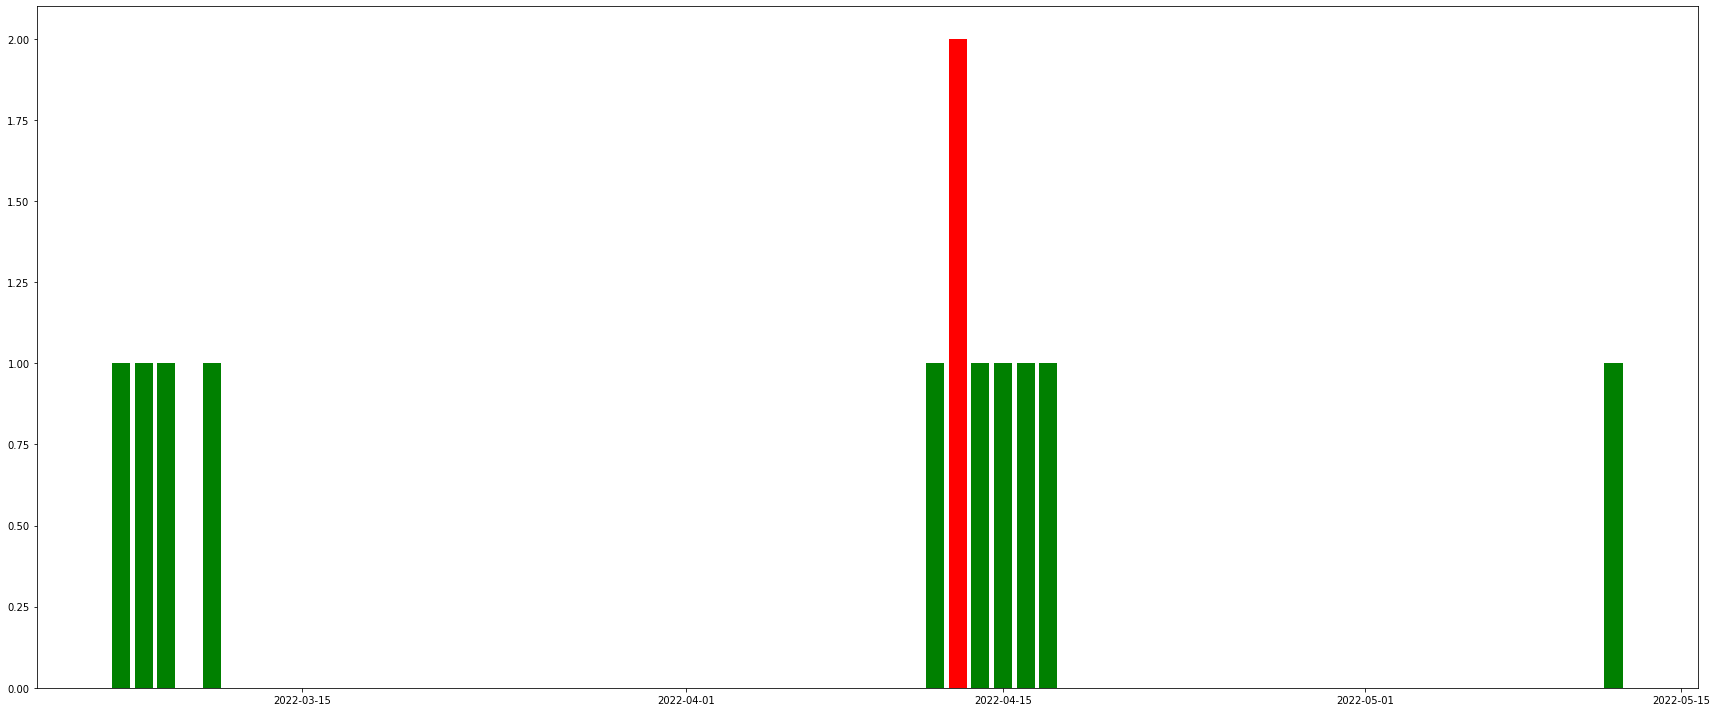

In [24]:
values = np.array(list(opened_incidents_df['date_start'].tolist()))   
idx = np.array(list(opened_incidents_df['date'].tolist())) 
clrs = ['red' if (x > THRESHOLD) else 'green' for x in values ]
plt.bar(idx, values, color=clrs)
plt.show()

#### Top 10 Dates with the highest amount of incidents

In [25]:
top_ten_dates_df = incidents_df['date_start'].dt.date.value_counts().sort_values(ascending=False).to_frame().head(10).reset_index().rename(columns={'index' : 'date'})

In [26]:
top_ten_dates_df

,date,date_start
0,2022-04-13,2
1,2022-03-07,1
2,2022-03-08,1
3,2022-03-09,1
4,2022-05-12,1
5,2022-03-11,1
6,2022-04-12,1
7,2022-04-14,1
8,2022-04-15,1
9,2022-04-16,1


<a id='drift'></a>
## 3️⃣. 📈 Most drifted features

Parameter to Set:    

`THRESHOLD` - This parameter will color in red features that have drifted beyond the threshold (Default: 5)

THRESHOLD = *5*

In [27]:
THRESHOLD = 5 # @param

In [28]:
request_url  = f'{URL_PREFIX}/model/v1/versions/{VERSION_ID}/data_entities'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()

features = pd.DataFrame(res.json())
version_entities = pd.DataFrame(res.json(), columns=["data_entity", "feature_importance"])
flatten_version_entities = pd.json_normalize(version_entities["data_entity"], max_level=0)
flatten_version_entities["feature_importance"] = version_entities["feature_importance"]
empty_flatten_version_entities = pd.DataFrame(
    columns=["id", "name", "role", "type", "secondary_type", "summary", "dimension_start_ts"]
)
features = empty_flatten_version_entities.append(flatten_version_entities)
features['role'] = pd.json_normalize(features['role'])['description']
features = features[features['role'] == 'feature']
features = features[["id","name","type","feature_importance"]]

features.head()

,id,name,type,feature_importance
0,151,Transaction amount,Numeric,0.118245
1,152,Is weekend transaction,Boolean,0.050936
2,153,Is night transaction,Boolean,0.046186
3,154,Customer 1d transaction amount,Numeric,0.047133
4,155,Customer avg 1d spend,Numeric,0.074043


In [29]:
ENTITY_IDS= features.id.to_list()
print(len(ENTITY_IDS))

15


In [30]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics-functions'
res = requests.get(request_url, headers=HEADERS)
res.raise_for_status()
metrics = pd.DataFrame(res.json()) 
metrics.head()

,id,name,description,is_overall,type,is_percent,cap,floor,tooltip_text,tooltip_url,model_id,prediction_entity_id,label_entity_id,prediction_positive_value,label_positive_value,config_name
0,1,distribution_shift,Distribution Shift,False,distribution,False,100.0,0.0,Measure the statistical distance between the d...,None,NaN,NaN,NaN,None,None,None
1,2,min_value,Min Value,False,distribution,False,NaN,NaN,"For each time frame, the minimal value that wa...",None,NaN,NaN,NaN,None,None,None
2,3,max_value,Max Value,False,distribution,False,NaN,NaN,"For each time frame, the maximal value that wa...",None,NaN,NaN,NaN,None,None,None
3,4,sum_value,Sum Value,False,distribution,False,NaN,NaN,"For each time frame, the sum value that was de...",None,NaN,NaN,NaN,None,None,None
4,5,mean_value,Mean Value,False,distribution,False,NaN,NaN,"For each time frame, the mean value that was d...",None,NaN,NaN,NaN,None,None,None


In [31]:
METRIC_ID=metrics.set_index('name').loc['distribution_shift']['id'] 
METRIC_ID

1

In [32]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics'
requests_params = dict(task_id=MODEL_ID, vesrion_id=VERSION_ID, entity_id=ENTITY_IDS, segment_id=-1, metric_id=[METRIC_ID], time_unit='D')
res = requests.get(request_url,params=requests_params,headers=HEADERS)
res.raise_for_status()
results_df =  pd.DataFrame(res.json())
results_df['entity_name'] = results_df['entity_id'].map(features.set_index('id')['name'].to_dict())
results_df['date_hour'] = pd.to_datetime(results_df['date_hour'])
results_df.head()

,id,task_id,version_id,segment_id,dimension_id,date_hour,time_unit,category,entity_id,metric_id,value,value_json,model_id,entity_name
0,c77218a7b29b01da1ab58b987f54a107,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,151,1,2.686583,{},8,Transaction amount
1,5939fb919a986a1ea86e6ea5208ea8d4,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,165,1,0.355792,{},8,Terimnal avg 30d spend
2,f71677a0559b89dca3e177bcf8fa74b6,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,164,1,12.694677,{},8,Terimnal 30d transaction amount
3,4d33d1ce092652d5935e7acb572941ea,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,163,1,0.198034,{},8,Terimnal avg 7d spend
4,5cdd43044df7f2d2bdc6bbde812e86ae,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,162,1,3.986872,{},8,Terimnal 7d transaction amount


In [33]:
results_df = results_df[results_df['date_hour'].max() == results_df['date_hour']]
results_df = results_df[['entity_name','value']]
results_df = results_df.sort_values('value', ascending=False)

#### Drift score per feature

In [34]:
results_df.sort_values('value', ascending=False).set_index('entity_name').plot.bar()

<a id='segment'></a>
##4️⃣. 🌎 Most drifted segments

Parameter to Set:    

`THRESHOLD` - This parameter will color in red features that have drifted beyond the threshold (Default: 5)

In [35]:
THRESHOLD = 12.5 # @param

In [36]:
METRIC_ID=metrics.set_index('name').loc['quantity']['id'] 
METRIC_ID

13

In [37]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics'
requests_params = dict(task_id=MODEL_ID, vesrion_id=VERSION_ID, entity_id=-1, metric_id=[METRIC_ID], time_unit='D')
res = requests.get(request_url,params=requests_params,headers=HEADERS)
res.raise_for_status()
results_df =  pd.DataFrame(res.json())
results_df['entity_name'] = results_df['entity_id'].map(features.set_index('id')['name'].to_dict())
results_df['date_hour'] = pd.to_datetime(results_df['date_hour'])
results_df = results_df[['segment_id','value']]
results_df = results_df.groupby('segment_id').agg('sum').reset_index()
results_df['segment_size'] = results_df['value'] / float(results_df['value'].sum()) 
results_df = results_df[['segment_id','segment_size']]
results_df.head()

,segment_id,segment_size
0,-1,0.980780
1,29,0.005580
2,30,0.005562
3,31,0.005565
4,32,0.002513


In [38]:
request_url  = f'{URL_PREFIX}/admin/v1/segments?task_id={MODEL_ID}'
res = requests.get(request_url,params=requests_params,headers=HEADERS)
res.raise_for_status()
segments_df = pd.DataFrame(res.json())
segments_df = segments_df[['id','name']].rename(columns={'id': 'segment_id'})
segments_df.head(5)

,segment_id,name
0,29,Mobile users
1,30,Web users
2,32,Mobile users - high amount
3,31,Weak spot (Auto-generated)


In [39]:
segments_df = pd.merge(segments_df, results_df, how='left', on=['segment_id'],suffixes=['_segments','_kpis'])
segments_df.head()

,segment_id,name,segment_size
0,29,Mobile users,0.005580
1,30,Web users,0.005562
2,32,Mobile users - high amount,0.002513
3,31,Weak spot (Auto-generated),0.005565


In [42]:
metrics.set_index('name').loc['input_drift'] 
METRIC_ID=metrics.set_index('name').loc['input_drift']['id'] 
METRIC_ID

11

In [43]:
request_url  = f'{URL_PREFIX}/kpi/v1/metrics'
requests_params = dict(task_id=MODEL_ID, vesrion_id=VERSION_ID, entity_id=-1, metric_id=[METRIC_ID], time_unit='D')
res = requests.get(request_url,params=requests_params,headers=HEADERS)
res.raise_for_status()
results_df =  pd.DataFrame(res.json())
results_df['entity_name'] = results_df['entity_id'].map(features.set_index('id')['name'].to_dict())
results_df['date_hour'] = pd.to_datetime(results_df['date_hour'])
results_df.head()

,id,task_id,version_id,segment_id,dimension_id,date_hour,time_unit,category,entity_id,metric_id,value,value_json,model_id,entity_name
0,d62d4d4481807208c362a664e5c349dc,8,7,32,-1,2022-05-17 00:00:00+00:00,D,D,-1,11,9.139930,{},8,NaN
1,d0c03d2057eb15b3b2e5a87d5a35804d,8,7,-1,-1,2022-05-17 00:00:00+00:00,D,D,-1,11,6.595408,{},8,NaN
2,2f239aaeb1c095061057e58962f16abc,8,7,29,-1,2022-05-17 00:00:00+00:00,D,D,-1,11,8.397038,{},8,NaN
3,f4a8cbfbe9b2b6b872c5b2ddd270b078,8,7,30,-1,2022-05-17 00:00:00+00:00,D,D,-1,11,8.243756,{},8,NaN
4,02f522bd756a6e980225f27f51c2f86f,8,7,31,-1,2022-05-17 00:00:00+00:00,D,D,-1,11,7.754861,{},8,NaN


In [44]:
results_df = results_df.groupby('segment_id').mean().reset_index()[["segment_id","value"]]
results_df.head()

,segment_id,value
0,-1,4.300018
1,29,5.483083
2,30,5.123258
3,31,5.251776
4,32,7.642694


In [45]:
segments_df = pd.merge(segments_df,results_df,how='left').fillna(0)
segments_drift_df = segments_df[["name","value"]]
segments_drift_df.head()

,name,value
0,Mobile users,5.483083
1,Web users,5.123258
2,Mobile users - high amount,7.642694
3,Weak spot (Auto-generated),5.251776


#### Mean Segment Drift 

In [46]:
from matplotlib import pyplot as plt

segments_drift_df.sort_values('value',ascending=False).set_index('name').plot.bar()

#### Realtionship between segment size and segment drift

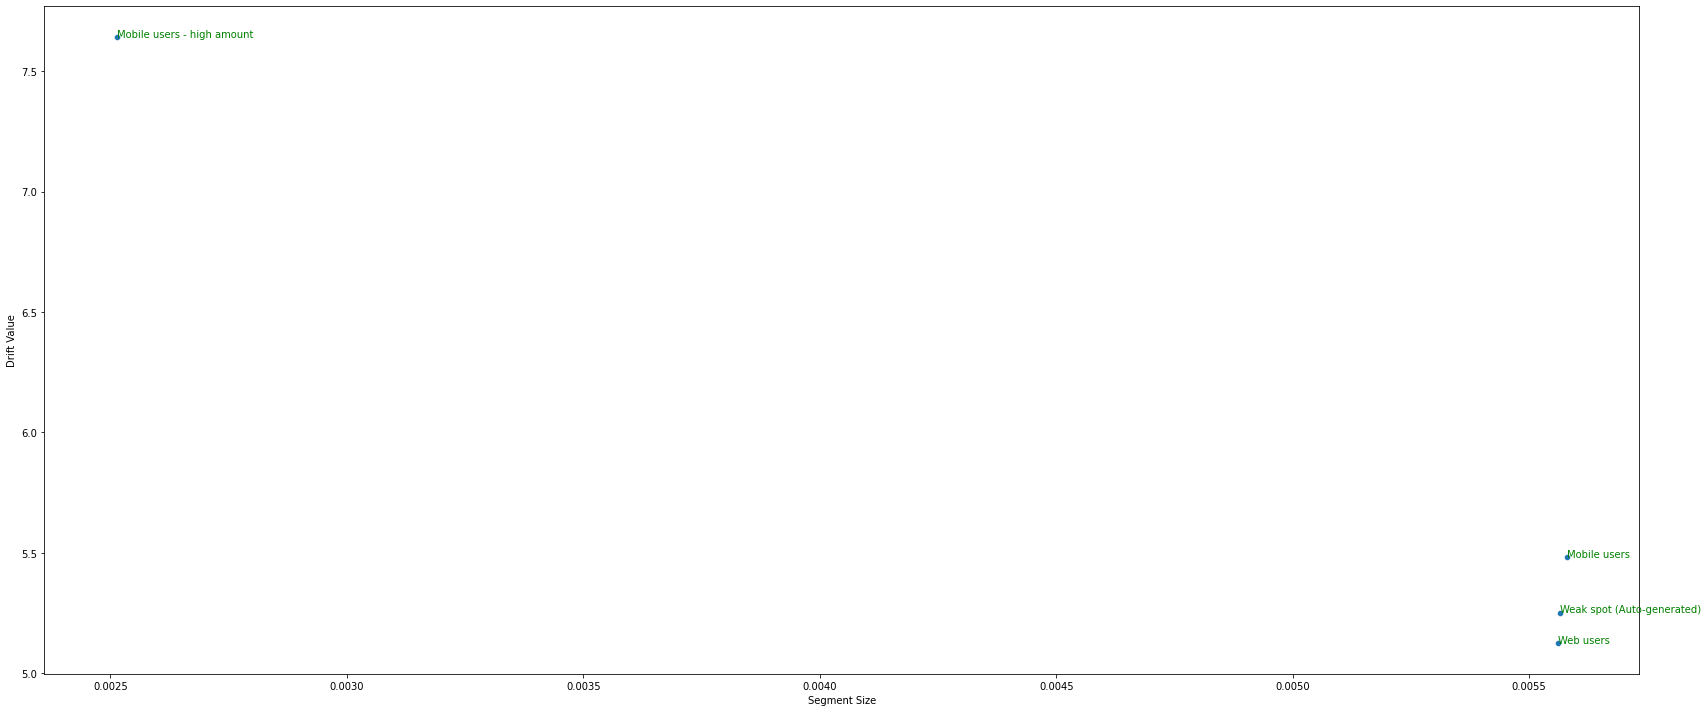

In [47]:
import matplotlib.pyplot as plt
import numpy as np
x = segments_df['segment_size'].to_list()
y = segments_df['value'].to_list()
colors = list(map(lambda x: "red" if x > THRESHOLD else "green", y))
labels = segments_df['name'].to_list()
sns.scatterplot(data=segments_df,x='segment_size',y='value')
for i in range(segments_df.shape[0]):
 plt.text(s=labels[i],x=x[i],y=y[i],
          fontdict=dict(color=colors[i],size=10))
plt.xlabel("Segment Size") #x label
plt.ylabel("Drift Value") #y label

plt.show()